In [ ]:
import pandas as pd

# Lê o arquivo com o caminho correto
df = pd.read_csv('/content/Atleticac.csv')

# Visualiza as primeiras linhas
print(df.head())


  Situacao da Compra Tipo de Compra Data da Compra Campanha de Vendas  \
0           Aprovado   Baixa Manual     09/05/2025  Atlética ESPM Rio   
1           Aprovado     Aplicativo     09/05/2025  Atlética ESPM Rio   
2           Aprovado     Aplicativo     09/05/2025  Atlética ESPM Rio   
3           Aprovado     Aplicativo     09/05/2025  Atlética ESPM Rio   
4           Aprovado     Aplicativo     09/05/2025  Atlética ESPM Rio   

            Vendedor Usuario baixa    Comprador Cpf do Comprador   RA  \
0     Heitor Furtado   luana assis  luana assis      17261645788  NaN   
1  Atlética ESPM Rio   Maria Luiza  Maria Luiza      43441550846  NaN   
2  Atlética ESPM Rio   Maria Luiza  Maria Luiza      43441550846  NaN   
3  Atlética ESPM Rio   Maria Luiza  Maria Luiza      43441550846  NaN   
4  Atlética ESPM Rio   Maria Luiza  Maria Luiza      43441550846  NaN   

  Telefone do Comprador  Endereco                       Produto Tamanho  \
0                   NaN       NaN  College ESPM

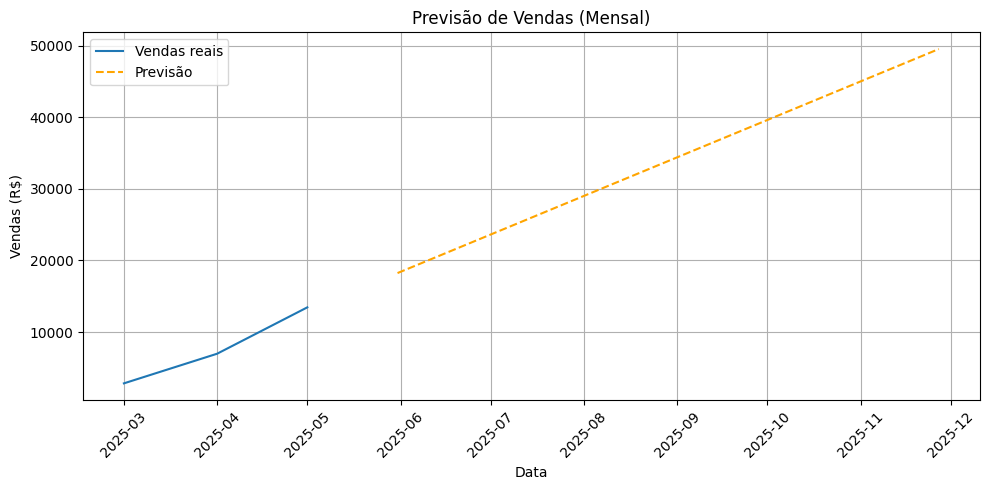

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Função para transformar "R$ 120,00" em float
def parse_valor(valor):
    if isinstance(valor, str):
        return float(valor.replace("R$", "").replace(".", "").replace(",", "."))
    return float(valor)

# Parâmetro: 'diario', 'semanal' ou 'mensal'
modo_previsao = 'mensal'  # <-- altere aqui o tipo de previsão

# Carregar o CSV
df = pd.read_csv("/content/Atleticac.csv")
df = df.rename(columns={"Data da Compra": "data"})
df["data"] = pd.to_datetime(df["data"], dayfirst=True)
df["valor_total"] = df["Valor Total"].map(parse_valor)

# Agrupamento
if modo_previsao == 'diario':
    df_agg = df.groupby("data")["valor_total"].sum().reset_index()
elif modo_previsao == 'semanal':
    df["semana"] = df["data"].dt.to_period("W").apply(lambda r: r.start_time)
    df_agg = df.groupby("semana")["valor_total"].sum().reset_index()
    df_agg = df_agg.rename(columns={"semana": "data"})
elif modo_previsao == 'mensal':
    df["mes"] = df["data"].dt.to_period("M").dt.to_timestamp()
    df_agg = df.groupby("mes")["valor_total"].sum().reset_index()
    df_agg = df_agg.rename(columns={"mes": "data"})
else:
    raise ValueError("modo_previsao deve ser 'diario', 'semanal' ou 'mensal'")

# Regressão
df_agg["dias"] = (df_agg["data"] - df_agg["data"].min()).dt.days
X = df_agg[["dias"]]
y = df_agg["valor_total"]

modelo = LinearRegression()
modelo.fit(X, y)

# Previsão dos próximos períodos
passo = 1 if modo_previsao == 'diario' else 7 if modo_previsao == 'semanal' else 30
futuro_dias = range(X["dias"].max() + passo, X["dias"].max() + passo * 8, passo)
dias_futuros = pd.DataFrame({"dias": futuro_dias})
previsoes = modelo.predict(dias_futuros)

# Datas futuras
ultima_data = df_agg["data"].max()
datas_futuras = pd.date_range(ultima_data + pd.Timedelta(days=passo), periods=7, freq=f"{passo}D")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_agg["data"], y, label="Vendas reais")
plt.plot(datas_futuras, previsoes, label="Previsão", linestyle="--", color="orange")
plt.legend()
plt.xlabel("Data")
plt.ylabel("Vendas (R$)")
plt.title(f"Previsão de Vendas ({modo_previsao.capitalize()})")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Gerando gráfico semanal...


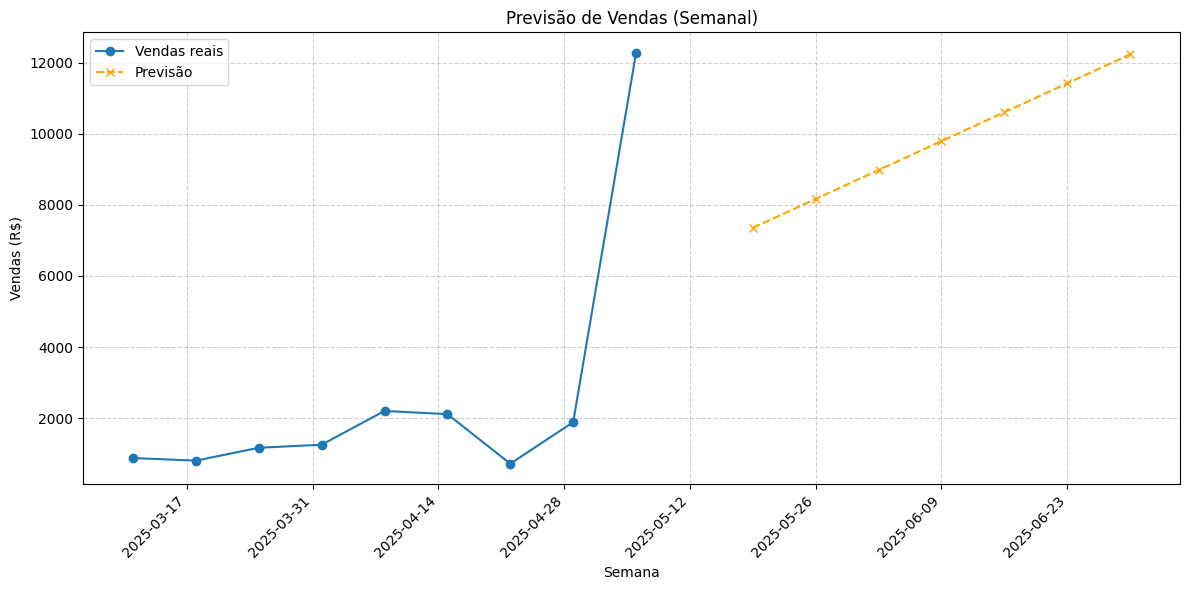


Gerando gráfico mensal...


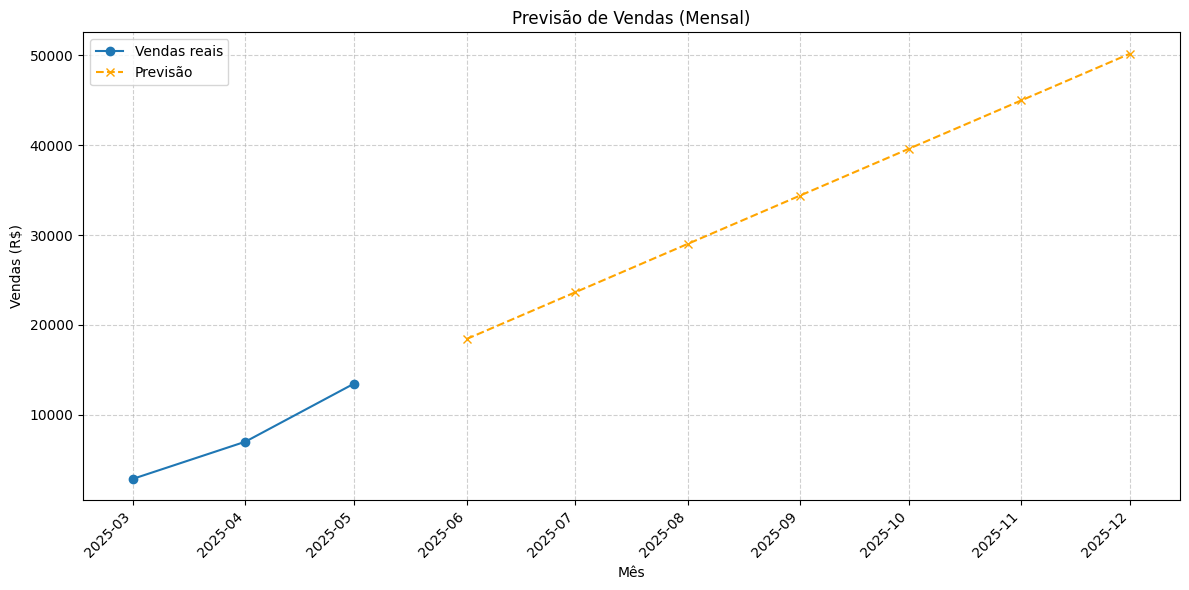


Gráficos gerados.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates # Importar para formatação de datas no eixo X

# Função para transformar "R$ 120,00" em float
def parse_valor(valor):
    if isinstance(valor, str):
        # Remove 'R$', espaços e usa '.' como separador decimal
        valor_limpo = valor.replace("R$", "").replace(".", "").replace(",", ".").strip()
        # Trata casos onde pode sobrar string vazia após limpeza
        if not valor_limpo:
            return 0.0
        return float(valor_limpo)
    # Garante que valores não-string sejam convertidos para float
    return float(valor) if pd.notna(valor) else 0.0

# Função para gerar agregação, previsão e gráfico
def gerar_grafico_previsao(df_original, modo_previsao, ax=None):
    """
    Agrega os dados, realiza a regressão linear, prevê valores futuros
    e plota o gráfico para um determinado modo ('semanal' ou 'mensal').

    Args:
        df_original (pd.DataFrame): O DataFrame original com os dados de vendas.
        modo_previsao (str): 'semanal' ou 'mensal'.
        ax (matplotlib.axes.Axes, optional): Eixo para plotar. Se None, cria nova figura.
    """
    # Cria uma cópia para não modificar o DataFrame original dentro da função
    df = df_original.copy()

    # --- Agrupamento ---
    if modo_previsao == 'semanal':
        # Garante que a semana comece na segunda-feira (padrão ISO)
        df["data_agg"] = df["data"].dt.to_period("W-MON").apply(lambda r: r.start_time)
        df_agg = df.groupby("data_agg")["valor_total"].sum().reset_index()
        passo = 7 # Dias em uma semana
        freq_str = 'W-MON' # Frequência semanal começando na segunda
        label_data = "Semana"

    elif modo_previsao == 'mensal':
        df["data_agg"] = df["data"].dt.to_period("M").dt.to_timestamp()
        df_agg = df.groupby("data_agg")["valor_total"].sum().reset_index()
        # Calcula o passo como a média de dias no mês para a previsão
        passo = 30.44 # Média de dias em um mês
        freq_str = pd.DateOffset(months=1) # Frequência mensal
        label_data = "Mês"
    else:
        raise ValueError("modo_previsao deve ser 'semanal' ou 'mensal'")

    df_agg = df_agg.rename(columns={"data_agg": "data"})

    # Verifica se há dados suficientes para a regressão
    if len(df_agg) < 2:
        print(f"Aviso: Dados insuficientes para gerar previsão {modo_previsao}. Mínimo 2 pontos.")
        return # Retorna se não houver dados suficientes

    # --- Regressão ---
    # Usar a representação numérica da data (timestamp) para regressão
    df_agg["timestamp"] = df_agg["data"].apply(lambda x: x.timestamp())
    X = df_agg[["timestamp"]]
    y = df_agg["valor_total"]

    modelo = LinearRegression()
    modelo.fit(X, y)

    # --- Previsão dos próximos períodos ---
    num_previsoes = 7 # Quantidade de períodos futuros a prever
    ultima_data = df_agg["data"].max()
    datas_futuras = pd.date_range(start=ultima_data, periods=num_previsoes + 1, freq=freq_str)[1:] # Pega a partir do próximo período

    # Cria timestamps para as datas futuras para usar no predict
    timestamps_futuros = pd.DataFrame({"timestamp": [d.timestamp() for d in datas_futuras]})
    previsoes = modelo.predict(timestamps_futuros)
    # Garante que previsões não sejam negativas (opcional, mas faz sentido para vendas)
    previsoes[previsoes < 0] = 0

    # --- Plot ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) # Cria nova figura e eixo se não for fornecido

    ax.plot(df_agg["data"], y, label="Vendas reais", marker='o', linestyle='-')
    ax.plot(datas_futuras, previsoes, label="Previsão", linestyle="--", marker='x', color="orange")
    ax.legend()
    ax.set_xlabel(label_data)
    ax.set_ylabel("Vendas (R$)")
    ax.set_title(f"Previsão de Vendas ({modo_previsao.capitalize()})")
    ax.grid(True, linestyle='--', alpha=0.6)

    # Melhorar formatação do eixo X para datas
    if modo_previsao == 'mensal':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Marcar cada mês
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Formato Ano-Mês
    elif modo_previsao == 'semanal':
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2, byweekday=mdates.MO)) # Marcar a cada 2 segundas-feiras
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formato Ano-Mês-Dia

    # Rotacionar os labels do eixo X para melhor legibilidade
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Mostra o gráfico se ele foi criado nesta função (ax era None)
    if 'fig' in locals():
         plt.show()


# --- Código Principal ---

# Carregar o CSV
try:
    df_principal = pd.read_csv("/content/Atleticac.csv") # Use um nome diferente para o df carregado
except FileNotFoundError:
    print("Erro: Arquivo 'Atleticac.csv' não encontrado. Verifique o caminho.")
    exit() # Termina o script se o arquivo não for encontrado

# Renomear colunas e converter tipos
df_principal = df_principal.rename(columns={"Data da Compra": "data", "Valor Total": "valor_total_str"})
try:
    df_principal["data"] = pd.to_datetime(df_principal["data"], dayfirst=True, errors='coerce') # Tenta converter, NaT se falhar
    df_principal["valor_total"] = df_principal["valor_total_str"].apply(parse_valor)
except KeyError as e:
    print(f"Erro: Coluna não encontrada no CSV - {e}. Verifique os nomes das colunas ('Data da Compra', 'Valor Total').")
    exit()
except Exception as e:
    print(f"Erro ao processar colunas: {e}")
    exit()

# Remover linhas onde a data não pôde ser convertida
df_principal.dropna(subset=['data'], inplace=True)

# Verificar se o DataFrame está vazio após limpeza
if df_principal.empty:
    print("Erro: DataFrame vazio após processamento inicial. Verifique os dados no CSV.")
    exit()

# --- Gerar os Gráficos ---

print("Gerando gráfico semanal...")
gerar_grafico_previsao(df_principal, 'semanal')

print("\nGerando gráfico mensal...")
gerar_grafico_previsao(df_principal, 'mensal')

print("\nGráficos gerados.")

# Opcional: Se quiser plotar ambos no mesmo conjunto de eixos (subgráficos)
# fig, axs = plt.subplots(2, 1, figsize=(12, 12)) # Cria 2 subplots (um em cima do outro)
# gerar_grafico_previsao(df_principal, 'semanal', ax=axs[0])
# gerar_grafico_previsao(df_principal, 'mensal', ax=axs[1])
# plt.tight_layout() # Ajusta o layout geral
# plt.show() # Mostra a figura com ambos os subplots